## test normalisation


In [12]:
import numpy as np
import rasterio
from rasterio.features import shapes, geometry_mask
import rioxarray
import json
import os
from skimage import exposure as skimage_exposure
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure

In [9]:

# dataPath = '/Users/maaikeizeboud/Documents/Data/test/'
homedir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'

# dataPath = os.path.join(homedir,'Data/test/')
# imName = 'S2_comp_first.tif'

dataPath = os.path.join(homedir,'Data/tiles/training_tiles')
imName = 'S2_composite_2019-11-1_2020-3-1_tile_50.tif'
# imName = 'S2_composite_2019-11-1_2020-3-1_tile_110.tif'


bands = rioxarray.open_rasterio(os.path.join(dataPath , imName) )
bands.rio.bounds()


(-1625050.0, -875030.0, -1500000.0, -750000.0)

## Test histogram equalization etc

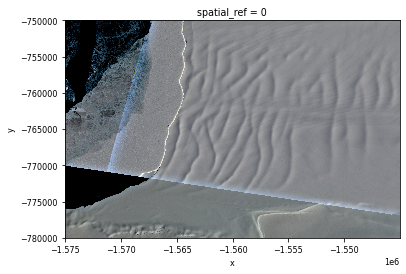

In [10]:
bands.shape
image = bands.isel(band=[0,1,2],y=np.arange(0,3000,1),x=np.arange(5000,8000,1)).transpose('y','x','band')
image.attrs['long_name'] = 'bandnames'
# image.isel(band=0).plot.imshow()
image.plot.imshow(rgb='band',vmin=4000,vmax=15000)

In [11]:



matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


def plot_multiple_histogram_techniques(img):
    
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    # img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    img_rescale = exposure.rescale_intensity(image.values, in_range=(0, 10000))#(p2, p98))

    # Equalization
    img_eq = exposure.equalize_hist(img)

    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    

    # Display results
    fig = plt.figure(figsize=(18, 12))
    axes = np.zeros((2, 4), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 4, 1)
    for i in range(1, 4):
        axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 4):
        axes[1, i] = fig.add_subplot(2, 4, 5+i)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
    ax_img.set_title('Contrast stretching')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
    ax_img.set_title('Histogram equalization')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
    ax_img.set_title('Adaptive equalization')

    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()

    
    
# plot_multiple_histogram_techniques(image.values)


## equalisation on each band

In [5]:
from skimage import exposure
import time
# from skimage import exposure as sk.exposure
from skimage.util import img_as_float64

start_time = time.time()
b1 = bands.isel(band=0,y=np.arange(0,3000,1),x=np.arange(5000,8000,1))#.transpose('y','x','band')
b2 = bands.isel(band=1,y=np.arange(0,3000,1),x=np.arange(5000,8000,1))#.transpose('y','x','band')
b3 = bands.isel(band=2,y=np.arange(0,3000,1),x=np.arange(5000,8000,1))#.transpose('y','x','band')

b1_fl = img_as_float64(b1)
b1_eq = exposure.equalize_adapthist(b1_fl, clip_limit=0.03)
b2_eq = exposure.equalize_adapthist(b2, clip_limit=0.03)
b3_eq = exposure.equalize_adapthist(b3, clip_limit=0.03)

# b1_eq = exposure.equalize_adapthist(img_as_float(b1), clip_limit=0.03)

print("--- %s seconds ---" % (time.time() - start_time))
print("{} --> {} ".format(bands.shape, b1.shape))
print('MIN values: {:.1f}, {:.1f}, {:.1f} '.format( b1.min().values, b1_fl.min(), b1_eq.min()))
print('MAX values: {:.1f}, {:.1f}, {:.1f} '.format( b1.max().values, b1_fl.max(), b1_eq.max()))

--- 5.046336889266968 seconds ---
(4, 12503, 12505) --> (3000, 3000) 
MIN values: 1.0, 0.0, 0.0 
MAX values: 16096.0, 0.2, 1.0 


In [12]:
band_data = img_as_float64(b1.values)
band_data.max()

0.2456092164492256

In [14]:
import matplotlib.pyplot as plt
from skimage.util import img_as_uint
print(b1.dtype,b1.min().values,b1.max().values)
# print(b3_eq.min(),b3_eq.max())
b1_f = img_as_float(b1)
b1_u = img_as_uint(b1)
print(b1_f.dtype, b1_f.min(),b1_f.max())
print(b1_u.dtype, b1_u.min(),b1_u.max())
b1.attrs['long_name']='hoi'
# plt.figure()
# b1.plot.imshow()
# plt.figure()
# plt.imshow(b1_f)
# plt.colorbar()

uint16 1 16096
float64 1.5259021896696422e-05 0.2456092164492256
uint16 1 16096


In [15]:
import skimage
skimage.__version__

'0.19.3'

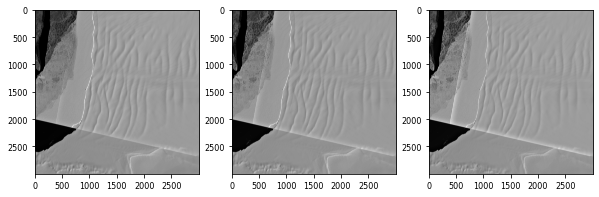

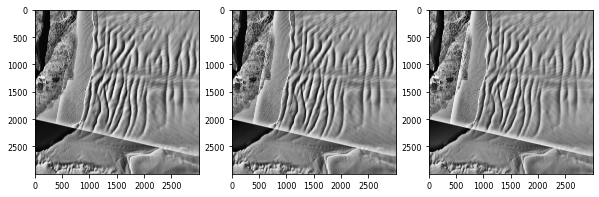

In [18]:

fig,ax=plt.subplots(1,3,figsize=(10,8))

ax[0].imshow(b1,cmap='gray')
ax[1].imshow(b2,cmap='gray')
ax[2].imshow(b3,cmap='gray')

fig,ax=plt.subplots(1,3,figsize=(10,8))

ax[0].imshow(b1_eq,cmap='gray')
ax[1].imshow(b2_eq,cmap='gray')
ax[2].imshow(b3_eq,cmap='gray')

In [ ]:
# full img (takes forever)

# start_time = time.time()
# b1 = bands.isel(band=0)
# b2 = bands.isel(band=1)
# b3 = bands.isel(band=2)

# b1_eq = exposure.equalize_adapthist(b1, clip_limit=0.03)
# b2_eq = exposure.equalize_adapthist(b2, clip_limit=0.03)
# b3_eq = exposure.equalize_adapthist(b3, clip_limit=0.03)

# print("--- %s seconds ---" % (time.time() - start_time))
# print("{} --> {} ".format(bands.shape, b1.shape))

--- 252.12182188034058 seconds ---
(4, 12503, 12505) --> (12503, 12505) 


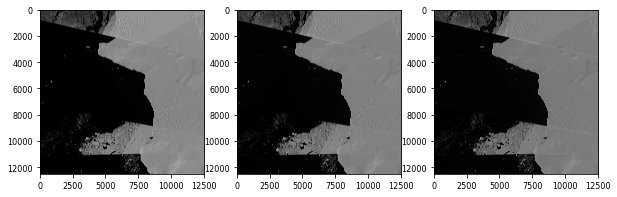

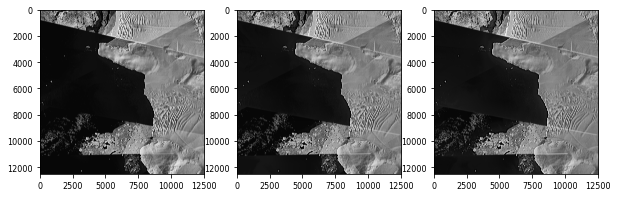

In [ ]:
# fig,ax=plt.subplots(1,3,figsize=(10,8))

# ax[0].imshow(b1,cmap='gray')
# ax[1].imshow(b2,cmap='gray')
# ax[2].imshow(b3,cmap='gray')

# fig,ax=plt.subplots(1,3,figsize=(10,8))

# ax[0].imshow(b1_eq,cmap='gray')
# ax[1].imshow(b2_eq,cmap='gray')
# ax[2].imshow(b3_eq,cmap='gray')

In [ ]:
n_bands = bands['band'].shape[0]
n_bands
bands_sub = bands.isel(y=np.arange(5000,8000),x=np.arange(0,5000))
print(bands_sub.shape)
all_band=np.empty(bands_sub.shape)
for band_i in range(n_bands):
    band_data = bands_sub.isel(band=band_i)
    band_data_eq =  skimage_exposure.equalize_adapthist(band_data, clip_limit=0.03)
    # print(np.expand_dims(band_data_eq,axis=0).shape)
    all_band[band_i] = np.expand_dims(band_data_eq,axis=0)

(4, 3000, 5000)
(1, 3000, 5000)
(1, 3000, 5000)
(1, 3000, 5000)
(1, 3000, 5000)


In [ ]:
tmp_band = np.expand_dims(b1_eq,axis=0)
all_band_eq = np.concatenate((tmp_band,tmp_band,tmp_band,tmp_band),axis=0)
all_band_eq.shape

(4, 12503, 12505)

In [ ]:
# # da_eq = xr.DataArray(data= all_band, 
# #                     coords=(bands["band"], bands["y"], bands["x"] ), 
# #                     dims=("band","y","x"), name="adapthist", 
# #                     attrs=bands.attrs, indexes=bands.indexes)#, fastpath=False)
# # import xarray as xr
# da_eq = xr.DataArray(data= all_band_eq, 
#                     coords=(bands["band"], bands["y"], bands["x"] ), 
#                     dims=("band","y","x"), name="adapthist", 
#                     attrs=bands.attrs, indexes=bands.indexes)#, fastpath=False)

## apply ocean mask and THEN equalise

In [25]:

def normalise_and_equalise(da,normThreshold=None,equalise=False):
    
    # normalize
    if normThreshold is not None:
        da = (da + 0.1) / (normThreshold + 1)
        da = da.clip(max=1)
    
    if equalise:
        # hist equalist
        if len(da.shape) == 3:
            n_bands = da['band'].shape[0]
            all_band_eq=np.empty(da.shape)

            for band_i in range(n_bands): # perform adaptive normalisation per band
                band_data = da.isel(band=band_i)
                band_data_eq = skimage_exposure.equalize_adapthist(band_data, clip_limit=0.03)
                all_band_eq[band_i] = np.expand_dims(band_data_eq,axis=0)

            da = da.copy(data=all_band_eq) # overwrite data in dataArray
        else: # 2D matrix
            data_eq = skimage_exposure.equalize_adapthist(da, clip_limit=0.03)
            da = da.copy(data=data_eq) # overwrite data in dataArray

    
    return da

In [24]:
len(data_origin.shape)

2

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt

iceshelf_poly_path = os.path.join(homedir,'Data/ne_10m_antarctic_ice_shelves_polys/ne_10m_antarctic_ice_shelves_polys.shp')
iceshelf_poly = gpd.read_file(iceshelf_poly_path).to_crs(epsg=3031)


''' ----------
Mask ocean
------------'''
gdf = iceshelf_poly
data_origin = image.isel(band=0) # bands (image=part of full bands-img)
# mask = data.copy(data=np.ones_like(data.values)) # set up img with only 1 vluess
# mask = mask.rio.clip(gdf.geometry, gdf.crs, drop=False, invert=False) # mask 
data_masked = data_origin.rio.clip(gdf.geometry, gdf.crs, drop=False, invert=False) # mask 






In [32]:
''' ----------
Normalise
------------'''
data_norm = normalise_and_equalise(data_masked,normThreshold=10000,equalise=False)

In [33]:
''' ----------
Equalise
------------'''

data_equal = normalise_and_equalise(data_masked,normThreshold=None,equalise=True)
data_norm_eq = normalise_and_equalise(data_norm,normThreshold=None,equalise=True)

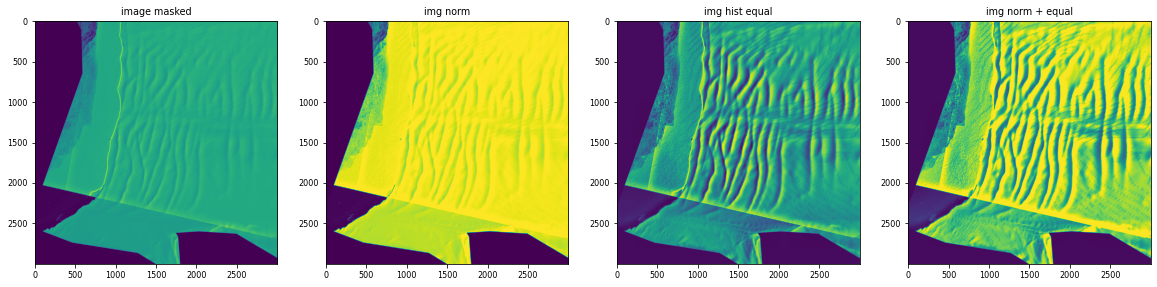

In [34]:
fig,axs = plt.subplots(1,4,figsize=(20,12))
# axs[0].imshow(data.isel(band=0)) 
axs[0].imshow(data_masked)
axs[1].imshow(data_norm)
axs[2].imshow(data_equal)
axs[3].imshow(data_norm_eq)
axs[0].set_title('image masked');
axs[1].set_title('img norm');
axs[2].set_title('img hist equal');
axs[3].set_title('img norm + equal');

In [15]:
# ### demo: as in dataset.py


# start_time = time.time()

# # normalize with threshold
# # if self.norm_threshold is not None:
# norm_threshold=[10000]
# # da = (da + 0.1) / (self.norm_threshold + 1) # normalises to [0 1] using  v_max= norm_threshold nd v_min=0, but with a small addition to omit 0/x
# # da = da.clip(max=1)
# if len(norm_threshold) ==1:
#     norm_min=0
#     norm_max=norm_threshold[0]
# elif len(norm_threshold) == 2:
#     norm_min, norm_max = norm_threshold

# # normliise using norm_min nd norm_max values
# da = (da - norm_min) / (norm_max - norm_min)
# da = da.clip(min=0,max=1)


# # hist equalist
# n_bands = da['band'].shape[0]
# all_band_eq=np.empty(da.shape)

# for band_i in range(n_bands): # perform adaptive normalisation per band
#     band_data = da.isel(band=band_i)
#     band_data_eq = skimage_exposure.equalize_adapthist(band_data, clip_limit=0.03)
#     all_band_eq[band_i] = np.expand_dims(band_data_eq,axis=0)

# da_equal = da.copy(data=all_band_eq) # overwrite data in dataArray


# print("--- %s seconds ---" % (time.time() - start_time))
